In [154]:
import os
import numpy as np
import IPython
import copy
from shutil import copyfile

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

import sys
sys.dont_write_bytecode=True

PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from influence.inceptionModel2 import BinaryInceptionModel
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
import influence.experiments
from influence.dataset import DataSet
# from influence.dataset_poisoning import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.iter_attack import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.Progress import *

from load_animals import *

from skimage import io

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
img_side = 299
num_channels = 3
 
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]

weight_decay = 0.001

num_classes = 2
max_lbfgs_iter = 1000

# num_train_ex = 1800
# num_test_ex = 600
# batch_size = 100

# dataset_name = 'dogfish_%s_%s' % (num_train_ex, num_test_ex)
# # data_sets = load_animals(
# #     num_train_ex_per_class=num_train_ex_per_class, 
# #     num_test_ex_per_class=num_test_ex_per_class,
# #     classes=['dog', 'fish'])
# # data_sets = load_dogfish_with_orig_and_koda()
# # X, Y = load_koda()
# # print(X.shape, Y.shape)
# data_sets = new_load_dogfish_with_koda(num_train_ex, num_test_ex)

num_train_ex_per_class = 900
num_test_ex_per_class = 300
batch_size = 100

dataset_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
# extract_and_rename_animals()
data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
#     classes=['Eagle', 'Komodo_Dragon', 'Snail', 'Ox', 'Mushroom'])
    classes=['dog', 'fish'])

np.random.seed()

full_graph = tf.Graph()
top_graph = tf.Graph()

def render_img(img):
    img_copy = np.copy(img)
    img_copy /= 2
    img_copy += 0.5
    io.imshow(img_copy)

Loading animals from disk...


In [156]:
print('*** Full:')
with full_graph.as_default():
    full_model_name = '%s_inception_wd-%s' % (dataset_name, weight_decay)
    full_model = BinaryInceptionModel(
        img_side=img_side,
        num_channels=num_channels,
        weight_decay=weight_decay,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=True,
        train_dir='output',
        log_dir='log',
        model_name=full_model_name)
    
    for data_set, label in [
        (data_sets.train, 'train'),
        (data_sets.test, 'test')]:

        inception_features_path = 'output/%s_inception_features_new_%s.npz' % (dataset_name, label)
        if not os.path.exists(inception_features_path):

            print('Inception features do not exist. Generating %s...' % label)
            data_set.reset_batch()
            
            num_examples = data_set.num_examples
#             assert num_examples % batch_size == 0

            inception_features_val = generate_inception_features(
                full_model, 
                data_set.x, 
                data_set.labels, 
                batch_size=batch_size)
            
            np.savez(
                inception_features_path, 
                inception_features_val=inception_features_val,
                labels=data_set.labels)
            
train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
inception_X_train = DataSet(train_f['inception_features_val'], train_f['labels'])
test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
inception_X_test = DataSet(test_f['inception_features_val'], test_f['labels'])

validation = None

inception_data_sets = base.Datasets(train=inception_X_train, validation=validation, test=inception_X_test)

print('*** Top:')
with top_graph.as_default():
    top_model_name = '%s_inception_onlytop_wd-%s' % (dataset_name, weight_decay)
    input_dim = 2048
    top_model = BinaryLogisticRegressionWithLBFGS(
        input_dim=input_dim,
        weight_decay=weight_decay,
        max_lbfgs_iter=max_lbfgs_iter,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=inception_data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=False,
        train_dir='output',
        log_dir='log',
        model_name=top_model_name)
    weights = top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)
    orig_weight_path = 'output/inception_weights_%s.npy' % top_model_name
    np.save(orig_weight_path, weights)
    
with full_graph.as_default():
    full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=True)

### Create poisoned dataset
print('Creating poisoned dataset...')

step_size = 0.02
print('step_size is', step_size)

num_train = len(data_sets.train.labels)
num_test = len(data_sets.test.labels)
max_num_to_poison = 10

### Try attacking each test example individually

# orig_X_train = np.copy(data_sets.train.x)
# orig_Y_train = np.copy(data_sets.train.labels)

test_indices_to_attack = [179]


for test_idx in test_indices_to_attack:

    print('****** Attacking test_idx %s ******' % test_idx)
    test_description = test_idx

    # If this has already been successfully attacked, skip
    filenames = [filename for filename in os.listdir('./output') if (
        (('%s_attack_testidx-%s_trainidx-' % (full_model.model_name, test_description)) in filename) and        
        (filename.endswith('stepsize-%s_proj_final.npz' % step_size)))]
        # and (('stepsize-%s_proj_final.npz' % step_size) in filename))] # Check all step sizes        
    if len(filenames) > 0:
        print('test_idx %s has already been successfully attacked. Skipping...')
        continue
        
    # Use top model to quickly generate inverse HVP
#     dup_incep = DataSet(np.copy(inception_X_test.x), np.copy(inception_X_test.labels))
#     dup_incep.labels[test_idx] = 0

    with top_graph.as_default():
        get_hvp(
            top_model,
            inception_X_test, inception_X_train,
            test_description=test_description,
            test_idx = [test_idx],
            force_refresh=True)
    copyfile(
        'output/%s-test-%s.npz' % (top_model_name, test_description),
        'output/%s-test-%s.npz' % (full_model_name, test_description))
        
    # Use full model to select indices to poison
    with full_graph.as_default():
        grad_influence_wrt_input_val_subset = get_grad_of_influence_wrt_input(full_model, 
                                                    [test_idx], data_sets.test, 
                                                    np.arange(num_train), data_sets.train, 
                                                    test_description,
                                                    force_refresh=False)
        # save into file for caching 
        print("finished calculating grad_wrt_input_val")
        pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
        all_indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
#     all_indices_to_poison =  [1141,1454,1447,158,306,1484,1589,1354,721,1295]
    print("-----------------------")
    print("-----------------------")
    print("all_indices_to_poison: ", all_indices_to_poison)
    # for 15: 999,  172, 1302,  492, 1446,  164,  153, 1186,   47,  575

    for num_to_poison in [0.1]:
        # If we're just attacking one training example, try attacking the first one and also the second one separately
        if num_to_poison == 0.1:
#             indices_to_poison = all_indices_to_poison[0:1]
            indices_to_poison = all_indices_to_poison[0:1]
            print('indices_to_poison', indices_to_poison)
        elif num_to_poison == 1.2:
            indices_to_poison = all_indices_to_poison[1:2]
        else:
            indices_to_poison = all_indices_to_poison[:num_to_poison]
        
        orig_X_train_subset = np.copy(data_sets.train.x[indices_to_poison, :])
        orig_X_train_inception_features_subset = np.copy(inception_X_train.x[indices_to_poison, :])

        project_fn = get_projection_to_box_around_orig_point(orig_X_train_subset, box_radius_in_pixels=0.5)

        attack_success = iterative_attack(top_model, full_model, top_graph, full_graph, project_fn, 
                                          [test_idx], 
                                          test_description, 
                                          data_sets.train, data_sets.test, dataset_name,
                                          indices_to_poison=indices_to_poison,
                                          num_iter=100,
                                          step_size=step_size,
                                          save_iter=100,
                                          early_stop=0.5,
#                                           target_labels=[0]
                                            )
        
        new_incep_feat = np.copy(inception_X_train.x[indices_to_poison, :])

        with full_graph.as_default():
            data_sets.train.x[indices_to_poison, :] = orig_X_train_subset
            full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=False)
        with top_graph.as_default():
            inception_X_train.x[indices_to_poison, :] = orig_X_train_inception_features_subset
            top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)

#         if attack_success:
#             break

*** Full:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:194 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
*** Top:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:194 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012129042
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039761304
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.048454043
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 3.6090015e-07
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0380473


LBFGS training took [41] iter.
After training with LBFGS: 


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: [0.01212904]
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00397613]
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.04845405]
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   [0.985]
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 3.601257e-07
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0380473


Creating poisoned dataset...
('step_size is', 0.02)
****** Attacking test_idx 179 ******
Total number of parameters: 2048
         Current function value: -0.177720
         Iterations: 6
         Function evaluations: 79
         Gradient evaluations: 73
         Hessian evaluations: 45
Inverse HVP took 3.41958904266 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000687837600708 sec
Entering the for loop
finished calculating grad_wrt_input_val


[iter_attack.py:122 -     iterative_attack() ] Test idx: [179], Indices to poison: [1141], train label: [1.], test label: 0.0


-----------------------
-----------------------
('all_indices_to_poison: ', array([1141, 1454, 1447,  158,  306, 1484, 1589, 1354,  721, 1295]))
('indices_to_poison', array([1141]))



[iter_attack.py:135 -     iterative_attack() ] Initial Test pred (full): [[0.9973924  0.00260756]]
[iter_attack.py:138 -     iterative_attack() ] Initial Test pred (top): [[0.9973924  0.00260756]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 0


Total number of parameters: 2048
         Current function value: -0.177720
         Iterations: 6
         Function evaluations: 79
         Gradient evaluations: 73
         Hessian evaluations: 45
Inverse HVP took 2.391258955 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000522136688232 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 0 perturbation shape: (1, 268203), perturbation: [[-0.00329253 -0.00111468  0.00228367 ...  0.00212297 -0.00142142
   0.00035609]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.4264717102050781, mean: -5.450868395668965e-06, min: -0.3750772476196289


[[-0.00329253 -0.00111468  0.00228367 ...  0.00212297 -0.00142142
   0.00035609]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01213258
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.003974339
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04817948
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00013029587
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0393662
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99685514 0.00314489]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99685514 0.00314489]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 1


LBFGS training took [36] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -0.256596
         Iterations: 5
         Function evaluations: 81
         Gradient evaluations: 75
         Hessian evaluations: 41
Inverse HVP took 2.43024587631 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000584125518799 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 1 perturbation shape: (1, 268203), perturbation: [[-0.00285624  0.00043309  0.00264105 ...  0.00149586 -0.0013652
   0.00043285]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.4937315583229065, mean: -3.36094413146442e-06, min: -0.44190508127212524


[[-0.00285624  0.00043309  0.00264105 ...  0.00149586 -0.0013652
   0.00043285]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012142721
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.003971027
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047830462
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00033394695
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.042695
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9962204 0.0037796]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9962204 0.0037796]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 2


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
Optimization terminated successfully.
         Current function value: -0.367456
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 16
         Hessian evaluations: 44
Inverse HVP took 0.934890985489 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000495910644531 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 2 perturbation shape: (1, 268203), perturbation: [[-0.00200757  0.00248914  0.00347116 ...  0.00081993 -0.00153073
   0.00112398]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.5197025537490845, mean: -1.3507586133652033e-06, min: -0.5650953054428101


[[-0.00200757  0.00248914  0.00347116 ...  0.00081993 -0.00153073
   0.00112398]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01216062
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039657266
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047478642
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0006633848
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.04843
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99544525 0.00455482]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99544525 0.00455482]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 3


LBFGS training took [40] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -0.528128
         Iterations: 7
         Function evaluations: 84
         Gradient evaluations: 80
         Hessian evaluations: 58
Inverse HVP took 2.6862180233 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000549077987671 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 3 perturbation shape: (1, 268203), perturbation: [[-0.00091197  0.00418671  0.00521318 ...  0.00267368 -0.0020982
   0.00057957]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.7537000179290771, mean: 5.604274394706856e-06, min: -0.6585286855697632


[[-0.00091197  0.00418671  0.00521318 ...  0.00267368 -0.0020982
   0.00057957]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01218502
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039653867
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047061723
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.000951859
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.054536
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99453086 0.00546911]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99453086 0.00546911]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 4


LBFGS training took [37] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -0.753037
         Iterations: 8
         Function evaluations: 196
         Gradient evaluations: 188
         Hessian evaluations: 69
Inverse HVP took 5.68821597099 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000869035720825 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 4 perturbation shape: (1, 268203), perturbation: [[-0.00404774  0.00507357  0.00943167 ... -0.00029564 -0.00290833
   0.00285763]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.8382042646408081, mean: 6.015877054005796e-06, min: -0.8619764447212219


[[-0.00404774  0.00507357  0.00943167 ... -0.00029564 -0.00290833
   0.00285763]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01221646
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039689755
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04663074
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0012375185
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0614
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9934284  0.00657154]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9934284  0.00657154]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 5


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1.074458
         Iterations: 7
         Function evaluations: 77
         Gradient evaluations: 72
         Hessian evaluations: 49
Inverse HVP took 2.44334506989 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000509023666382 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 5 perturbation shape: (1, 268203), perturbation: [[-0.00192294  0.00471012  0.00798488 ...  0.00175368 -0.00458664
   0.0038421 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 0.9646959900856018, mean: 5.410288587922521e-06, min: -1.0467766523361206


[[-0.00192294  0.00471012  0.00798488 ...  0.00175368 -0.00458664
   0.0038421 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01225128
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.003975561
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046222884
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0014643407
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0683455
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.99212897 0.00787107]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.99212897 0.00787107]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 6


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1.522676
         Iterations: 6
         Function evaluations: 80
         Gradient evaluations: 74
         Hessian evaluations: 47
Inverse HVP took 2.53393101692 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000531911849976 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 6 perturbation shape: (1, 268203), perturbation: [[-0.00596078  0.00612885  0.01148605 ... -0.00261342 -0.00521783
   0.00668087]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 1.3276634216308594, mean: 1.2394587083535053e-05, min: -1.4697335958480835


[[-0.00596078  0.00612885  0.01148605 ... -0.00261342 -0.00521783
   0.00668087]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012290955
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.003986548
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045772813
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0016619281
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0753913
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9904537  0.00954629]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9904537  0.00954629]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 7


LBFGS training took [41] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2.212455
         Iterations: 7
         Function evaluations: 134
         Gradient evaluations: 128
         Hessian evaluations: 54
Inverse HVP took 4.0176820755 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000557899475098 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 7 perturbation shape: (1, 268203), perturbation: [[-0.00533669  0.00860246  0.01901068 ...  0.00511152 -0.00546183
   0.0048032 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 1.875858187675476, mean: 8.994452915573654e-06, min: -2.404407262802124


[[-0.00533669  0.00860246  0.01901068 ...  0.00511152 -0.00546183
   0.0048032 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012340638
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.003997975
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0454532
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0019634017
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.0847673
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.98842245 0.01157753]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.98842245 0.01157753]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 8


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3.211183
         Iterations: 6
         Function evaluations: 71
         Gradient evaluations: 66
         Hessian evaluations: 44
Inverse HVP took 2.31193900108 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000588893890381 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 8 perturbation shape: (1, 268203), perturbation: [[-0.00613149  0.00330487  0.01740347 ...  0.00150202 -0.00695283
   0.00724595]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 2.549546718597412, mean: 1.7586912862500286e-05, min: -3.1389992237091064


[[-0.00613149  0.00330487  0.01740347 ...  0.00150202 -0.00695283
   0.00724595]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012384253
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004012634
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04519557
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0021105255
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.09185
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.98609746 0.01390256]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.98609746 0.01390256]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 9


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4.574962
         Iterations: 7
         Function evaluations: 148
         Gradient evaluations: 142
         Hessian evaluations: 49
Inverse HVP took 4.2818980217 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000552177429199 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 9 perturbation shape: (1, 268203), perturbation: [[-0.00885983  0.01272654  0.02538673 ... -0.01043672 -0.00131638
   0.00762192]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 2.9244556427001953, mean: 1.5587730854217334e-05, min: -3.5761516094207764


[[-0.00885983  0.01272654  0.02538673 ... -0.01043672 -0.00131638
   0.00762192]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012444714
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0040310593
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045049377
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0023900552
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1021094
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9830709  0.01692905]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9830709  0.01692905]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 10


LBFGS training took [44] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -6.690852
         Iterations: 8
         Function evaluations: 146
         Gradient evaluations: 141
         Hessian evaluations: 57
Inverse HVP took 4.33654689789 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00053882598877 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 10 perturbation shape: (1, 268203), perturbation: [[-0.00874088  0.01496634  0.03364722 ...  0.00064153 -0.01190341
   0.01516327]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 3.7179338932037354, mean: 6.306091687471135e-05, min: -4.208930492401123


[[-0.00874088  0.01496634  0.03364722 ...  0.00064153 -0.01190341
   0.01516327]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012497928
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0040496946
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04488654
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0025368428
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.110531
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.979627   0.02037293]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.979627   0.02037293]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 11


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -9.574277
         Iterations: 8
         Function evaluations: 123
         Gradient evaluations: 116
         Hessian evaluations: 59
Inverse HVP took 3.78332209587 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000566959381104 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 11 perturbation shape: (1, 268203), perturbation: [[ 0.00063693  0.01956982  0.03978709 ... -0.0037499   0.00736264
  -0.00053635]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 4.667914867401123, mean: 3.415961145269686e-05, min: -5.0382914543151855


[[ 0.00063693  0.01956982  0.03978709 ... -0.0037499   0.00736264
  -0.00053635]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012560014
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004071641
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0448077
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0027482791
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.120284
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9753676  0.02463238]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9753676  0.02463238]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 12


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -13.823343
         Iterations: 8
         Function evaluations: 77
         Gradient evaluations: 73
         Hessian evaluations: 55
Inverse HVP took 2.61510705948 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000554084777832 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 12 perturbation shape: (1, 268203), perturbation: [[-0.00932728  0.03298119  0.06215084 ...  0.00884423 -0.01786986
   0.01818479]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 5.42816162109375, mean: 9.45973395197116e-05, min: -6.3014655113220215


[[-0.00932728  0.03298119  0.06215084 ...  0.00884423 -0.01786986
   0.01818479]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012614826
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0040919525
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044716682
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0028659524
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1286497
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.97089684 0.02910311]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.97089684 0.02910311]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 13


LBFGS training took [44] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -19.088840
         Iterations: 8
         Function evaluations: 147
         Gradient evaluations: 140
         Hessian evaluations: 53
Inverse HVP took 4.26661300659 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000542879104614 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 13 perturbation shape: (1, 268203), perturbation: [[ 0.01253289  0.03776679  0.05244434 ... -0.01298592  0.01443529
  -0.00435581]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 5.439328193664551, mean: 1.9190507643087852e-05, min: -7.706676006317139


[[ 0.01253289  0.03776679  0.05244434 ... -0.01298592  0.01443529
  -0.00435581]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012670254
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041143135
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044861026
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9816666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0029907255
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.136651
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9654894  0.03451058]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9654894  0.03451058]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 14


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -26.549141
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 95
         Hessian evaluations: 57
Inverse HVP took 3.15439605713 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000540018081665 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 14 perturbation shape: (1, 268203), perturbation: [[ 0.01875177  0.04031828  0.07059405 ...  0.03051887 -0.03377135
   0.02406263]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 6.9013495445251465, mean: 0.0001197436904402022, min: -8.384195327758789


[[ 0.01875177  0.04031828  0.07059405 ...  0.03051887 -0.03377135
   0.02406263]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012724964
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041365847
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044843122
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9833333333333333
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0030941924
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1444855
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.95967746 0.0403225 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.95967746 0.0403225 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 15


LBFGS training took [40] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -35.864334
         Iterations: 8
         Function evaluations: 67
         Gradient evaluations: 64
         Hessian evaluations: 53
Inverse HVP took 2.28636097908 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00072193145752 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 15 perturbation shape: (1, 268203), perturbation: [[ 0.00406326  0.02931025  0.0734809  ... -0.02638539  0.01318517
  -0.00552121]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 8.134439468383789, mean: 5.97056411434359e-05, min: -12.04791259765625


[[ 0.00406326  0.02931025  0.0734809  ... -0.02638539  0.01318517
  -0.00552121]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012769543
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041572307
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04502115
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0031173094
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1502557
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9531182  0.04688176]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9531182  0.04688176]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 16


LBFGS training took [40] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -48.034966
         Iterations: 10
         Function evaluations: 75
         Gradient evaluations: 74
         Hessian evaluations: 73
Inverse HVP took 2.73816394806 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000509977340698 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 16 perturbation shape: (1, 268203), perturbation: [[-0.00736448  0.08446713  0.13050871 ...  0.05541776 -0.04075032
   0.02214366]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 10.673117637634277, mean: 0.0002127703495517565, min: -12.614419937133789


[[-0.00736448  0.08446713  0.13050871 ...  0.05541776 -0.04075032
   0.02214366]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01282149
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041772476
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04473636
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0032055976
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1579423
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9463879  0.05361208]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9463879  0.05361208]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 17


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -62.318768
         Iterations: 8
         Function evaluations: 102
         Gradient evaluations: 98
         Hessian evaluations: 52
Inverse HVP took 3.19123792648 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000576019287109 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 17 perturbation shape: (1, 268203), perturbation: [[-0.00922877  0.05612721  0.1595424  ... -0.00236363  0.01897348
  -0.00286746]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 12.125173568725586, mean: 7.810862530060744e-05, min: -13.63597297668457


[[-0.00922877  0.05612721  0.1595424  ... -0.00236363  0.01897348
  -0.00286746]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012863706
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0041963663
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04499613
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0032594018
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1634936
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9379963  0.06200364]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9379963  0.06200364]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 18


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -82.578285
         Iterations: 8
         Function evaluations: 86
         Gradient evaluations: 83
         Hessian evaluations: 51
Inverse HVP took 2.68442296982 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000595092773438 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 18 perturbation shape: (1, 268203), perturbation: [[-0.0392821   0.12022951  0.22439808 ...  0.0522511  -0.04489738
   0.01664941]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 11.051568984985352, mean: 0.00023036351119339792, min: -16.91704559326172


[[-0.0392821   0.12022951  0.22439808 ...  0.0522511  -0.04489738
   0.01664941]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012908915
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0042161276
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044762466
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0032786347
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.169601
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9295825  0.07041755]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9295825  0.07041755]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 19


LBFGS training took [36] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -105.633896
         Iterations: 10
         Function evaluations: 174
         Gradient evaluations: 171
         Hessian evaluations: 75
Inverse HVP took 5.17556095123 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00057315826416 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 19 perturbation shape: (1, 268203), perturbation: [[-0.01341787  0.13310193  0.29989144 ... -0.09730223  0.02970266
   0.03154254]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 14.721040725708008, mean: 8.344238133279027e-05, min: -22.13711166381836


[[-0.01341787  0.13310193  0.29989144 ... -0.09730223  0.02970266
   0.03154254]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012940887
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0042293468
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045068562
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0033345588
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1740966
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9203735  0.07962651]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9203735  0.07962651]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 20


LBFGS training took [44] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -134.025726
         Iterations: 9
         Function evaluations: 87
         Gradient evaluations: 85
         Hessian evaluations: 61
Inverse HVP took 2.88202810287 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00052285194397 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 20 perturbation shape: (1, 268203), perturbation: [[-0.10150929  0.08787131  0.2054393  ...  0.11862946 -0.07636942
   0.01878902]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 20.339736938476562, mean: 0.0002862386053577748, min: -24.40810203552246


[[-0.10150929  0.08787131  0.2054393  ...  0.11862946 -0.07636942
   0.01878902]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012999235
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004253201
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0447091
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.003415729
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.182352
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.9125733  0.08742677]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.9125733  0.08742677]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 21


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -160.707214
         Iterations: 10
         Function evaluations: 98
         Gradient evaluations: 96
         Hessian evaluations: 71
Inverse HVP took 3.38172888756 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000540971755981 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 21 perturbation shape: (1, 268203), perturbation: [[-0.00980277  0.0543599   0.20032011 ... -0.15939109  0.06020618
   0.02833015]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 23.951934814453125, mean: -3.673112721255817e-05, min: -24.735183715820312


[[-0.00980277  0.0543599   0.20032011 ... -0.15939109  0.06020618
   0.02833015]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013012862
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004259881
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045177866
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0034257714
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.1840124
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.90151745 0.09848259]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.90151745 0.09848259]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 22


LBFGS training took [34] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -202.092865
         Iterations: 8
         Function evaluations: 55
         Gradient evaluations: 51
         Hessian evaluations: 54
Inverse HVP took 1.97807002068 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000547885894775 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 22 perturbation shape: (1, 268203), perturbation: [[-0.10486473  0.20545679  0.37100938 ...  0.0538808  -0.07970785
   0.04245411]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 26.895160675048828, mean: 0.00040418870593534, min: -26.977062225341797


[[-0.10486473  0.20545679  0.37100938 ...  0.0538808  -0.07970785
   0.04245411]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013069937
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004282572
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.044840258
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0035366234
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.192223
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8917182  0.10828184]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8917182  0.10828184]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 23


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -243.100403
         Iterations: 10
         Function evaluations: 89
         Gradient evaluations: 87
         Hessian evaluations: 71
Inverse HVP took 3.08441495895 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000526905059814 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 23 perturbation shape: (1, 268203), perturbation: [[-0.06941493  0.06857805  0.29747093 ... -0.07463617 -0.01449311
   0.03941187]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 23.108009338378906, mean: -8.359054503180088e-05, min: -27.447406768798828


[[-0.06941493  0.06857805  0.29747093 ... -0.07463617 -0.01449311
   0.03941187]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013092451
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004291961
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045385838
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0035966192
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.195352
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.880135   0.11986503]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.880135   0.11986503]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 24


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -295.501343
         Iterations: 9
         Function evaluations: 135
         Gradient evaluations: 131
         Hessian evaluations: 65
Inverse HVP took 4.18266391754 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000596046447754 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 24 perturbation shape: (1, 268203), perturbation: [[-0.03756133  0.05761455  0.06884865 ...  0.05923962 -0.04950079
   0.06975731]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 23.939077377319336, mean: 0.0003561647943421126, min: -24.06325912475586


[[-0.03756133  0.05761455  0.06884865 ...  0.05923962 -0.04950079
   0.06975731]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01313941
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004312552
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045135915
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0036199107
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2016325
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.86883247 0.13116756]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.86883247 0.13116756]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 25


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -352.222778
         Iterations: 11
         Function evaluations: 83
         Gradient evaluations: 82
         Hessian evaluations: 77
Inverse HVP took 3.07096385956 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000540018081665 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 25 perturbation shape: (1, 268203), perturbation: [[-0.26367566  0.22147441  0.27222139 ... -0.00479014  0.00520364
   0.01604196]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 31.96924591064453, mean: -6.491181091421512e-05, min: -35.45606994628906


[[-0.26367566  0.22147441  0.27222139 ... -0.00479014  0.00520364
   0.01604196]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01315752
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043171155
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045632664
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0037697514
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.204855
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8563443  0.14365575]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8563443  0.14365575]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 26


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -419.398224
         Iterations: 10
         Function evaluations: 112
         Gradient evaluations: 109
         Hessian evaluations: 66
Inverse HVP took 3.59356784821 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00053596496582 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 26 perturbation shape: (1, 268203), perturbation: [[-0.02062617 -0.01203528  0.0256218  ... -0.08054481 -0.03510162
   0.11487775]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 30.70013427734375, mean: 7.106358437746785e-05, min: -32.407161712646484


[[-0.02062617 -0.01203528  0.0256218  ... -0.08054481 -0.03510162
   0.11487775]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01320922
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004339782
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045330375
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0038026015
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2117543
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.84525484 0.15474515]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.84525484 0.15474515]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 27


LBFGS training took [41] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -484.892609
         Iterations: 11
         Function evaluations: 89
         Gradient evaluations: 88
         Hessian evaluations: 81
Inverse HVP took 3.22079491615 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000539064407349 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 27 perturbation shape: (1, 268203), perturbation: [[-0.51873541  0.15382272  0.33903202 ...  0.17664568 -0.10713703
   0.00129297]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 38.69171905517578, mean: 0.00019936416933551062, min: -60.457420349121094


[[-0.51873541  0.15382272  0.33903202 ...  0.17664568 -0.10713703
   0.00129297]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013211401
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043392875
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045897894
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0038864226
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2123895
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.83389837 0.16610168]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.83389837 0.16610168]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 28


LBFGS training took [31] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -555.192078
         Iterations: 9
         Function evaluations: 85
         Gradient evaluations: 83
         Hessian evaluations: 60
Inverse HVP took 2.79144310951 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000786066055298 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 28 perturbation shape: (1, 268203), perturbation: [[ 0.00033183 -0.11516832 -0.01341793 ... -0.24041285  0.05254062
   0.1092375 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 40.74299621582031, mean: 0.00013611482518209088, min: -34.41164016723633


[[ 0.00033183 -0.11516832 -0.01341793 ... -0.24041285  0.05254062
   0.1092375 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013256721
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043599107
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045477964
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0039197076
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2182493
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8232748  0.17672522]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8232748  0.17672522]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 29


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -626.536011
         Iterations: 9
         Function evaluations: 81
         Gradient evaluations: 79
         Hessian evaluations: 55
Inverse HVP took 2.67680907249 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000550985336304 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 29 perturbation shape: (1, 268203), perturbation: [[-0.36405987  0.1148473   0.60642838 ...  0.22548528 -0.17281833
   0.05395016]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 46.576942443847656, mean: 0.00028969561372398144, min: -56.89354705810547


[[-0.36405987  0.1148473   0.60642838 ...  0.22548528 -0.17281833
   0.05395016]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013254967
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004356677
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04603843
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0040040696
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.218599
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.81197566 0.18802439]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.81197566 0.18802439]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 30


LBFGS training took [36] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -704.984253
         Iterations: 9
         Function evaluations: 99
         Gradient evaluations: 97
         Hessian evaluations: 61
Inverse HVP took 3.22925400734 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000550031661987 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 30 perturbation shape: (1, 268203), perturbation: [[-0.09821551 -0.1237591   0.02206403 ... -0.08929694  0.04263932
   0.08896565]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 46.646121978759766, mean: 0.0003302253906997052, min: -56.76503372192383


[[-0.09821551 -0.1237591   0.02206403 ... -0.08929694  0.04263932
   0.08896565]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0133063365
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043801
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04552605
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0040229936
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2252192
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.8020024  0.19799764]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.8020024  0.19799764]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 31


LBFGS training took [41] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -780.404175
         Iterations: 8
         Function evaluations: 70
         Gradient evaluations: 67
         Hessian evaluations: 50
Inverse HVP took 2.38830494881 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000504016876221 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 31 perturbation shape: (1, 268203), perturbation: [[-0.52792287  0.10895526  0.26054424 ...  0.14264233 -0.1187115
   0.0341907 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 69.13793182373047, mean: 0.00014430881503335068, min: -66.82160949707031


[[-0.52792287  0.10895526  0.26054424 ...  0.14264233 -0.1187115
   0.0341907 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013293005
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0043714317
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04616796
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0041350387
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.224115
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7925413  0.20745866]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7925413  0.20745866]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 32


LBFGS training took [22] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -851.928955
         Iterations: 10
         Function evaluations: 92
         Gradient evaluations: 90
         Hessian evaluations: 75
Inverse HVP took 3.16976499557 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000699996948242 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 32 perturbation shape: (1, 268203), perturbation: [[-0.12659846  0.10572919  0.24233273 ... -0.03525806 -0.04162611
   0.15302952]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 73.309814453125, mean: 0.00032761245683612407, min: -83.99238586425781


[[-0.12659846  0.10572919  0.24233273 ... -0.03525806 -0.04162611
   0.15302952]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013340002
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004394571
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045603905
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004075039
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2297587
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7828606  0.21713945]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7828606  0.21713945]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 33


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -932.302734
         Iterations: 10
         Function evaluations: 133
         Gradient evaluations: 131
         Hessian evaluations: 72
Inverse HVP took 4.15083789825 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000798940658569 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 33 perturbation shape: (1, 268203), perturbation: [[-0.16388108 -0.03302073  0.28179646 ...  0.14094612 -0.12424469
   0.0392102 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 80.26395416259766, mean: 0.00045869513097956103, min: -77.84284973144531


[[-0.16388108 -0.03302073  0.28179646 ...  0.14094612 -0.12424469
   0.0392102 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013331777
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004386709
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046051204
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004237952
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2296734
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7735675  0.22643247]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7735675  0.22643247]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 34


LBFGS training took [22] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1008.629517
         Iterations: 11
         Function evaluations: 32
         Gradient evaluations: 42
         Hessian evaluations: 85
Inverse HVP took 1.97386407852 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000555038452148 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 34 perturbation shape: (1, 268203), perturbation: [[-0.32730064  0.0120264   0.25647479 ... -0.42549574  0.06532046
   0.24678257]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 69.272216796875, mean: 0.00022547145309396213, min: -81.92347717285156


[[-0.32730064  0.0120264   0.25647479 ... -0.42549574  0.06532046
   0.24678257]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013365105
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044050026
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04571643
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0041546538
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.233226
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.76352346 0.2364765 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.76352346 0.2364765 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 35


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1098.228271
         Iterations: 9
         Function evaluations: 97
         Gradient evaluations: 94
         Hessian evaluations: 58
Inverse HVP took 3.17162799835 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000565052032471 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 35 perturbation shape: (1, 268203), perturbation: [[ 0.00567305  0.03046058  0.06185803 ...  0.41089043 -0.26016343
   0.05187456]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 73.17932891845703, mean: 0.0006091676377008592, min: -81.98567199707031


[[ 0.00567305  0.03046058  0.06185803 ...  0.41089043 -0.26016343
   0.05187456]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013377329
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044051786
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046058882
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00435607
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.236071
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7539171  0.24608286]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7539171  0.24608286]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 36


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1184.516602
         Iterations: 10
         Function evaluations: 66
         Gradient evaluations: 64
         Hessian evaluations: 60
Inverse HVP took 2.39947795868 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000549077987671 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 36 perturbation shape: (1, 268203), perturbation: [[-0.46639901 -0.02417767  0.38299155 ... -0.48014796  0.13140988
   0.22989184]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 74.23454284667969, mean: -3.79953484029258e-05, min: -99.40412902832031


[[-0.46639901 -0.02417767  0.38299155 ... -0.48014796  0.13140988
   0.22989184]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0133948885
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004415846
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.045880273
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004253375
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.237698
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.74481714 0.25518283]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.74481714 0.25518283]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 37


LBFGS training took [32] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1271.347290
         Iterations: 10
         Function evaluations: 233
         Gradient evaluations: 228
         Hessian evaluations: 68
Inverse HVP took 6.75517392159 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000504016876221 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 37 perturbation shape: (1, 268203), perturbation: [[ 0.0254205   0.09476952  0.19505027 ...  0.36046445 -0.15193112
   0.03192189]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 82.81856536865234, mean: 0.0006179291443405497, min: -96.76405334472656


[[ 0.0254205   0.09476952  0.19505027 ...  0.36046445 -0.15193112
   0.03192189]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013411838
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044191545
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04610325
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004435836
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.240916
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7359616  0.26403844]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7359616  0.26403844]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 38


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1356.564209
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 81
         Hessian evaluations: 49
Inverse HVP took 2.62524700165 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000528812408447 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 38 perturbation shape: (1, 268203), perturbation: [[-0.5271132  -0.15474905  0.21969268 ... -0.42321819  0.04652345
   0.25594655]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 93.18714904785156, mean: 0.000121807902986372, min: -99.29573822021484


[[-0.5271132  -0.15474905  0.21969268 ... -0.42321819  0.04652345
   0.25594655]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013423383
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004427698
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046008207
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004326702
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.241624
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.72569996 0.27430004]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.72569996 0.27430004]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 39


LBFGS training took [19] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1460.667480
         Iterations: 9
         Function evaluations: 135
         Gradient evaluations: 131
         Hessian evaluations: 52
Inverse HVP took 3.93887996674 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000746965408325 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 39 perturbation shape: (1, 268203), perturbation: [[ 0.01755932  0.2401053   0.32453647 ...  0.27560675 -0.09848991
   0.05382539]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 89.37135314941406, mean: 0.000684371273356339, min: -117.41703796386719


[[ 0.01755932  0.2401053   0.32453647 ...  0.27560675 -0.09848991
   0.05382539]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013455735
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044348277
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046109486
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004573727
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2475653
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.71773124 0.28226876]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.71773124 0.28226876]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 40


LBFGS training took [43] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1543.525879
         Iterations: 9
         Function evaluations: 99
         Gradient evaluations: 96
         Hessian evaluations: 58
Inverse HVP took 3.11075997353 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000574827194214 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 40 perturbation shape: (1, 268203), perturbation: [[-0.60523695 -0.08903354  0.31760797 ... -0.04820418 -0.15062723
   0.24923071]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 113.51392364501953, mean: 0.0002811857083782972, min: -95.6824722290039


[[-0.60523695 -0.08903354  0.31760797 ... -0.04820418 -0.15062723
   0.24923071]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013454217
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004441893
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.0461684
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004363038
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2455454
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.7076429  0.29235706]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.7076429  0.29235706]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 41


LBFGS training took [31] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1651.044434
         Iterations: 9
         Function evaluations: 147
         Gradient evaluations: 143
         Hessian evaluations: 58
Inverse HVP took 4.32082700729 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000874996185303 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 41 perturbation shape: (1, 268203), perturbation: [[-0.01522744  0.12045342  0.2604225  ...  0.03263358  0.06113926
   0.10584542]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 97.60444641113281, mean: 0.0006362262876789625, min: -97.24410247802734


[[-0.01522744  0.12045342  0.2604225  ...  0.03263358  0.06113926
   0.10584542]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01347874
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044441344
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046269245
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0046460694
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.250789
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.69987166 0.3001283 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.69987166 0.3001283 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 42


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1735.622803
         Iterations: 8
         Function evaluations: 90
         Gradient evaluations: 88
         Hessian evaluations: 49
Inverse HVP took 2.87379693985 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000542163848877 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 42 perturbation shape: (1, 268203), perturbation: [[-0.57415044  0.11227065  0.59700876 ...  0.12842309 -0.19104953
   0.16523723]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 88.86683654785156, mean: 0.00030569614019138833, min: -73.61561584472656


[[-0.57415044  0.11227065  0.59700876 ...  0.12842309 -0.19104953
   0.16523723]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013489448
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004456592
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04618777
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004441221
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.250378
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6896539 0.3103461]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6896539 0.3103461]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 43


LBFGS training took [32] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1852.113037
         Iterations: 8
         Function evaluations: 70
         Gradient evaluations: 66
         Hessian evaluations: 45
Inverse HVP took 2.20271897316 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00052809715271 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 43 perturbation shape: (1, 268203), perturbation: [[ 0.02884232  0.07334681  0.20086092 ... -0.0525989   0.06993634
   0.1458374 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 85.34130859375, mean: 0.000841155621580422, min: -102.19940948486328


[[ 0.02884232  0.07334681  0.20086092 ... -0.0525989   0.06993634
   0.1458374 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013489315
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044495305
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046298325
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0046771234
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2520075
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.68260854 0.31739143]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.68260854 0.31739143]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 44


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -1930.882080
         Iterations: 7
         Function evaluations: 77
         Gradient evaluations: 73
         Hessian evaluations: 37
Inverse HVP took 2.38937997818 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000536918640137 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 44 perturbation shape: (1, 268203), perturbation: [[-0.51656288  0.31102324  0.80792618 ...  0.04905881 -0.15981981
   0.16247842]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 84.18069458007812, mean: 0.0003448033936926484, min: -74.86146545410156


[[-0.51656288  0.31102324  0.80792618 ...  0.04905881 -0.15981981
   0.16247842]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013517868
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004467057
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046175715
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004512317
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2546
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6733879  0.32661217]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6733879  0.32661217]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 45


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2042.992188
         Iterations: 9
         Function evaluations: 83
         Gradient evaluations: 80
         Hessian evaluations: 61
Inverse HVP took 2.80718612671 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000548124313354 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 45 perturbation shape: (1, 268203), perturbation: [[ 0.09104584 -0.03514846  0.01142193 ... -0.33315027  0.28009081
   0.02350947]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 79.59080505371094, mean: 0.0007105350468546236, min: -107.07185363769531


[[ 0.09104584 -0.03514846  0.01142193 ... -0.33315027  0.28009081
   0.02350947]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013508869
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044579464
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046306793
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0047124317
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2546263
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.66488105 0.33511895]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.66488105 0.33511895]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 46


LBFGS training took [33] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2141.746582
         Iterations: 8
         Function evaluations: 74
         Gradient evaluations: 71
         Hessian evaluations: 44
Inverse HVP took 2.32487511635 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000555992126465 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 46 perturbation shape: (1, 268203), perturbation: [[-0.67598194  0.21019822  0.8512975  ...  0.13234681 -0.26215312
   0.24419674]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 97.026123046875, mean: 0.0008588687577867568, min: -79.10128784179688


[[-0.67598194  0.21019822  0.8512975  ...  0.13234681 -0.26215312
   0.24419674]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013543226
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044765132
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04623619
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004590791
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2583365
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.65673566 0.34326434]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.65673566 0.34326434]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 47


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2246.915283
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 81
         Hessian evaluations: 46
Inverse HVP took 2.64046692848 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000519990921021 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 47 perturbation shape: (1, 268203), perturbation: [[ 0.32240427  0.21708924  0.15516365 ... -0.2765573   0.00918902
   0.13508309]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 92.17414855957031, mean: 0.0002780443578185265, min: -109.79100036621094


[[ 0.32240427  0.21708924  0.15516365 ... -0.2765573   0.00918902
   0.13508309]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01353012
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044669523
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046359386
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0047409222
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2575035
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6471038  0.35289618]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6471038  0.35289618]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 48


LBFGS training took [23] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2364.242920
         Iterations: 10
         Function evaluations: 187
         Gradient evaluations: 181
         Hessian evaluations: 62
Inverse HVP took 5.39871096611 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000553846359253 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 48 perturbation shape: (1, 268203), perturbation: [[-1.02994311  0.14635575  0.84482014 ...  0.02465839 -0.37791795
   0.51658416]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 96.86871337890625, mean: 0.0014856877865521484, min: -78.47454071044922


[[-1.02994311  0.14635575  0.84482014 ...  0.02465839 -0.37791795
   0.51658416]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013570612
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004488161
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046330243
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0046682735
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2620306
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6408447  0.35915527]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6408447  0.35915527]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 49


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2450.033936
         Iterations: 9
         Function evaluations: 140
         Gradient evaluations: 136
         Hessian evaluations: 45
Inverse HVP took 4.0347969532 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000545978546143 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 49 perturbation shape: (1, 268203), perturbation: [[ 0.45588511  0.14599927  0.00235174 ... -0.13542719  0.16052252
  -0.08775492]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 130.77557373046875, mean: -0.0005574559043875733, min: -190.5435791015625


[[ 0.45588511  0.14599927  0.00235174 ... -0.13542719  0.16052252
  -0.08775492]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013547956
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044749826
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046496302
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0047214213
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.259806
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6329175  0.36708245]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6329175  0.36708245]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 50


LBFGS training took [22] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2549.415039
         Iterations: 9
         Function evaluations: 149
         Gradient evaluations: 144
         Hessian evaluations: 54
Inverse HVP took 4.16105794907 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000911235809326 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 50 perturbation shape: (1, 268203), perturbation: [[-0.95694363  0.16035455  0.91587508 ...  0.07667865 -0.3912091
   0.57279563]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 156.17178344726562, mean: 0.0025686451964506917, min: -142.3387908935547


[[-0.95694363  0.16035455  0.91587508 ...  0.07667865 -0.3912091
   0.57279563]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.0135971
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044978755
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04642301
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0048059733
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2659645
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6261583 0.3738416]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6261583 0.3738416]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 51


LBFGS training took [47] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2645.351807
         Iterations: 9
         Function evaluations: 91
         Gradient evaluations: 89
         Hessian evaluations: 54
Inverse HVP took 2.92045712471 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00061297416687 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 51 perturbation shape: (1, 268203), perturbation: [[ 0.43096551  0.17489453  0.02040604 ... -0.1934448   0.0934727
  -0.01870186]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 166.29551696777344, mean: -0.0009605961211250258, min: -154.16543579101562


[[ 0.43096551  0.17489453  0.02040604 ... -0.1934448   0.0934727
  -0.01870186]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01356245
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044837226
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046620414
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00468367
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.261157
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6168772 0.3831228]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6168772 0.3831228]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 52


LBFGS training took [37] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2765.681885
         Iterations: 8
         Function evaluations: 71
         Gradient evaluations: 67
         Hessian evaluations: 40
Inverse HVP took 2.1966919899 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000555992126465 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 52 perturbation shape: (1, 268203), perturbation: [[-0.81085682  0.22418332  1.0214808  ... -0.0576535  -0.17329247
   0.42272848]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 141.16647338867188, mean: 0.0025336585942486306, min: -162.455810546875


[[-0.81085682  0.22418332  1.0214808  ... -0.0576535  -0.17329247
   0.42272848]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013617508
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045055468
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04658453
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004875061
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.268949
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.609877   0.39012304]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.609877   0.39012304]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 53


LBFGS training took [51] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2868.787598
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 81
         Hessian evaluations: 46
Inverse HVP took 2.67244982719 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00054407119751 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 53 perturbation shape: (1, 268203), perturbation: [[ 0.14219248 -0.01264875 -0.08229129 ... -0.12485053 -0.07379362
   0.04954033]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 151.97036743164062, mean: -0.0011405862618189655, min: -155.90882873535156


[[ 0.14219248 -0.01264875 -0.08229129 ... -0.12485053 -0.07379362
   0.04954033]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013585471
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0044940272
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04665296
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0047094175
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.264139
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.6008137  0.39918634]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.6008137  0.39918634]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 54


LBFGS training took [36] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -2991.313477
         Iterations: 9
         Function evaluations: 82
         Gradient evaluations: 78
         Hessian evaluations: 44
Inverse HVP took 2.19826507568 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000544786453247 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 54 perturbation shape: (1, 268203), perturbation: [[-0.85259861  0.01455474  0.79593909 ...  0.27099818 -0.29604173
   0.3924652 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 117.84690856933594, mean: 0.003015442411571869, min: -129.31781005859375


[[-0.85259861  0.01455474  0.79593909 ...  0.27099818 -0.29604173
   0.3924652 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013635219
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004513832
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04678616
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0049141
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.271156
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5954546 0.4045454]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5954546 0.4045454]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 55


LBFGS training took [49] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3074.453125
         Iterations: 8
         Function evaluations: 68
         Gradient evaluations: 64
         Hessian evaluations: 42
Inverse HVP took 1.85216498375 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000542879104614 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 55 perturbation shape: (1, 268203), perturbation: [[ 0.22840899  0.3378396   0.23956348 ... -0.68042147  0.23270065
   0.04697061]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 166.45736694335938, mean: -0.0015183253143387012, min: -214.6603546142578


[[ 0.22840899  0.3378396   0.23956348 ... -0.68042147  0.23270065
   0.04697061]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013604639
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004501336
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046712458
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0047636004
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.26692
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5871093  0.41289067]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5871093  0.41289067]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 56


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3190.147705
         Iterations: 10
         Function evaluations: 87
         Gradient evaluations: 86
         Hessian evaluations: 59
Inverse HVP took 2.4980070591 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000542879104614 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 56 perturbation shape: (1, 268203), perturbation: [[-0.52284813  0.06771827  0.49780929 ...  0.49077609 -0.20968102
   0.26904812]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 131.46803283691406, mean: 0.0031167498464251104, min: -153.81275939941406


[[-0.52284813  0.06771827  0.49780929 ...  0.49077609 -0.20968102
   0.26904812]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013649551
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045201
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046900056
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004935832
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.273043
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5821047 0.4178953]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5821047 0.4178953]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 57


LBFGS training took [51] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3270.199219
         Iterations: 10
         Function evaluations: 77
         Gradient evaluations: 75
         Hessian evaluations: 54
Inverse HVP took 2.27225399017 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000540971755981 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 57 perturbation shape: (1, 268203), perturbation: [[-0.51396352  0.46626461  0.94550097 ... -0.31934378  0.14784865
   0.07585964]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 170.2511444091797, mean: -0.0009640165234845043, min: -179.8365478515625


[[-0.51396352  0.46626461  0.94550097 ... -0.31934378  0.14784865
   0.07585964]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01362369
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045092446
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046809107
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004808416
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.269531
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.57383895 0.42616102]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.57383895 0.42616102]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 58


LBFGS training took [32] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3389.838379
         Iterations: 10
         Function evaluations: 135
         Gradient evaluations: 132
         Hessian evaluations: 64
Inverse HVP took 3.62245106697 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000557899475098 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 58 perturbation shape: (1, 268203), perturbation: [[-0.05685174  0.09695986  0.37891251 ...  0.41874084 -0.24877056
   0.26261199]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 142.40188598632812, mean: 0.0027839489313117153, min: -160.8660430908203


[[-0.05685174  0.09695986  0.37891251 ...  0.41874084 -0.24877056
   0.26261199]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013669347
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045291698
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047031153
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004958372
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.275553
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5694367  0.43056327]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5694367  0.43056327]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 59


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3460.956543
         Iterations: 10
         Function evaluations: 143
         Gradient evaluations: 140
         Hessian evaluations: 58
Inverse HVP took 3.66718411446 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000529050827026 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 59 perturbation shape: (1, 268203), perturbation: [[-0.59073496  0.48745     1.10124528 ... -0.60954636  0.32694525
   0.14802361]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 147.79437255859375, mean: -0.0002769238495878458, min: -167.4723663330078


[[-0.59073496  0.48745     1.10124528 ... -0.60954636  0.32694525
   0.14802361]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013642324
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045151683
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046949267
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.00488754
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.272506
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5629799  0.43702012]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5629799  0.43702012]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 60


LBFGS training took [21] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3558.226562
         Iterations: 9
         Function evaluations: 84
         Gradient evaluations: 83
         Hessian evaluations: 47
Inverse HVP took 2.29591083527 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000545978546143 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 60 perturbation shape: (1, 268203), perturbation: [[ 0.00587128  0.09326845  0.19846439 ...  0.51060885 -0.22486353
   0.04769519]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 122.7696304321289, mean: 0.0023569253425335785, min: -137.80117797851562


[[ 0.00587128  0.09326845  0.19846439 ...  0.51060885 -0.22486353
   0.04769519]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013672578
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004533522
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047023155
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0048953407
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2752905
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.55971813 0.44028184]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.55971813 0.44028184]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 61


LBFGS training took [48] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3609.062256
         Iterations: 9
         Function evaluations: 77
         Gradient evaluations: 74
         Hessian evaluations: 40
Inverse HVP took 2.04632687569 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000513792037964 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 61 perturbation shape: (1, 268203), perturbation: [[-0.98391551  0.07813835  0.78631616 ... -0.44383615  0.13647634
   0.33618143]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 140.79322814941406, mean: -7.527083143797617e-05, min: -125.72000885009766


[[-0.98391551  0.07813835  0.78631616 ... -0.44383615  0.13647634
   0.33618143]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013658766
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045199147
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046961594
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004967319
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.275243
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.55373484 0.4462651 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.55373484 0.4462651 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 62


LBFGS training took [25] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3702.836426
         Iterations: 11
         Function evaluations: 156
         Gradient evaluations: 153
         Hessian evaluations: 69
Inverse HVP took 4.0289208889 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000541925430298 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 62 perturbation shape: (1, 268203), perturbation: [[-0.29574209  0.42206502  0.72181147 ...  0.54543358 -0.02455175
  -0.22451234]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 165.96551513671875, mean: 0.0016229889113420523, min: -127.55912780761719


[[-0.29574209  0.42206502  0.72181147 ...  0.54543358 -0.02455175
  -0.22451234]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013683943
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004540618
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04707383
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0048685693
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2762895
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5496241  0.45037594]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5496241  0.45037594]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 63


LBFGS training took [44] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3768.204102
         Iterations: 12
         Function evaluations: 147
         Gradient evaluations: 144
         Hessian evaluations: 85
Inverse HVP took 4.12276887894 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00053882598877 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 63 perturbation shape: (1, 268203), perturbation: [[-0.86621809  0.27629536  1.01159561 ... -0.2873632  -0.05991986
   0.46423587]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 149.6360321044922, mean: 0.00052786260394122, min: -155.78927612304688


[[-0.86621809  0.27629536  1.01159561 ... -0.2873632  -0.05991986
   0.46423587]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013678535
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004526603
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046948563
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.005053751
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2783012
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.54406124 0.45593882]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.54406124 0.45593882]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 64


LBFGS training took [48] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3857.165283
         Iterations: 9
         Function evaluations: 84
         Gradient evaluations: 81
         Hessian evaluations: 46
Inverse HVP took 2.39284896851 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000541210174561 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 64 perturbation shape: (1, 268203), perturbation: [[-0.22141126  0.33285162  0.27729517 ...  0.09981362 -0.12529586
   0.07421619]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 127.07391357421875, mean: 0.0009719876881906222, min: -122.40324401855469


[[-0.22141126  0.33285162  0.27729517 ...  0.09981362 -0.12529586
   0.07421619]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013689012
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004544869
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04720026
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0048381584
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2764807
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.53884614 0.46115384]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.53884614 0.46115384]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 65


LBFGS training took [23] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -3940.700195
         Iterations: 12
         Function evaluations: 139
         Gradient evaluations: 136
         Hessian evaluations: 68
Inverse HVP took 3.64550590515 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000529050827026 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 65 perturbation shape: (1, 268203), perturbation: [[-0.77999175  0.34255034  1.0709033  ...  0.18746932 -0.03221618
   0.21070695]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 168.25296020507812, mean: 0.0017045825065074396, min: -153.06117248535156


[[-0.77999175  0.34255034  1.0709033  ...  0.18746932 -0.03221618
   0.21070695]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013699488
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045336997
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046875298
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0051449984
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.281539
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.53522724 0.46477276]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.53522724 0.46477276]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 66


LBFGS training took [36] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4001.066895
         Iterations: 10
         Function evaluations: 68
         Gradient evaluations: 66
         Hessian evaluations: 63
Inverse HVP took 2.10218381882 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000547170639038 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 66 perturbation shape: (1, 268203), perturbation: [[ 0.07631403  0.24231616  0.29108155 ... -0.13492142  0.09865998
   0.18541639]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 136.23471069335938, mean: -0.00014058323258170946, min: -163.00936889648438


[[ 0.07631403  0.24231616  0.29108155 ... -0.13492142  0.09865998
   0.18541639]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013693044
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004547151
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04725216
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004819122
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.27689
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5283641  0.47163594]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5283641  0.47163594]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 67


LBFGS training took [31] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4111.189941
         Iterations: 8
         Function evaluations: 78
         Gradient evaluations: 74
         Hessian evaluations: 40
Inverse HVP took 2.0532720089 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000539064407349 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 67 perturbation shape: (1, 268203), perturbation: [[-1.01586604  0.18055212  0.84776264 ...  0.58097577 -0.26120669
  -0.06558273]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 230.81275939941406, mean: 0.0033393188430371526, min: -204.39700317382812


[[-1.01586604  0.18055212  0.84776264 ...  0.58097577 -0.26120669
  -0.06558273]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013721559
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004543479
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046877254
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.005229252
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2844086
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.52641445 0.47358558]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.52641445 0.47358558]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 68


LBFGS training took [46] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4147.314453
         Iterations: 10
         Function evaluations: 226
         Gradient evaluations: 222
         Hessian evaluations: 56
Inverse HVP took 5.40017485619 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000497817993164 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 68 perturbation shape: (1, 268203), perturbation: [[-0.16900542  0.31301719  0.5747112  ... -0.51266766  0.10778865
   0.4861269 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 155.36834716796875, mean: -0.0010318146905391496, min: -162.22622680664062


[[-0.16900542  0.31301719  0.5747112  ... -0.51266766  0.10778865
   0.4861269 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01369727
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004549842
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047307156
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0047652
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2772493
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.52195686 0.47804314]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.52195686 0.47804314]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 69


LBFGS training took [39] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4216.959961
         Iterations: 10
         Function evaluations: 89
         Gradient evaluations: 88
         Hessian evaluations: 53
Inverse HVP took 2.43126606941 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000539064407349 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 69 perturbation shape: (1, 268203), perturbation: [[-0.40630323 -0.00468528  0.14404511 ...  1.0936625  -0.14238584
  -0.40578869]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 226.13772583007812, mean: 0.004159755968620418, min: -229.13436889648438


[[-0.40630323 -0.00468528  0.14404511 ...  1.0936625  -0.14238584
  -0.40578869]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013731439
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004547311
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04688666
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.98
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0052776593
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.28582
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5202733 0.4797267]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5202733 0.4797267]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 70


LBFGS training took [45] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4250.129883
         Iterations: 8
         Function evaluations: 89
         Gradient evaluations: 87
         Hessian evaluations: 44
Inverse HVP took 2.32392787933 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000542879104614 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 70 perturbation shape: (1, 268203), perturbation: [[-1.01610422  0.56099665  1.58598375 ... -0.43681121  0.10273004
   0.6866715 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 223.58558654785156, mean: -0.0012753158193755203, min: -182.34814453125


[[-1.01610422  0.56099665  1.58598375 ... -0.43681121  0.10273004
   0.6866715 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013707602
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045539476
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047395978
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0048033674
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.278704
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.51360416 0.4863959 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.51360416 0.4863959 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 71


LBFGS training took [35] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4357.287109
         Iterations: 10
         Function evaluations: 73
         Gradient evaluations: 71
         Hessian evaluations: 59
Inverse HVP took 2.21851706505 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000523090362549 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 71 perturbation shape: (1, 268203), perturbation: [[ 0.04158297  0.13016516  0.01598635 ...  0.66452736 -0.24484542
  -0.1812163 ]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 208.56015014648438, mean: 0.004106746125103655, min: -199.86236572265625


[[ 0.04158297  0.13016516  0.01598635 ...  0.66452736 -0.24484542
  -0.1812163 ]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013743952
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004553264
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046852265
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.005257204
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2873507
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.51139957 0.4886004 ]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.51139957 0.4886004 ]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 72


LBFGS training took [44] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4400.220703
         Iterations: 9
         Function evaluations: 119
         Gradient evaluations: 117
         Hessian evaluations: 48
Inverse HVP took 3.01674199104 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000537872314453 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 72 perturbation shape: (1, 268203), perturbation: [[-0.99463683  0.13532841  1.2905494  ... -0.77763146  0.11039016
   0.71217537]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 203.9915771484375, mean: -0.0015015485747852174, min: -197.17916870117188


[[-0.99463683  0.13532841  1.2905494  ... -0.77763146  0.11039016
   0.71217537]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013713621
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004556783
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.04742767
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9766666666666667
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.0048377034
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.279448
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.50532526 0.49467474]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.50532526 0.49467474]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 73


LBFGS training took [42] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4496.739258
         Iterations: 10
         Function evaluations: 129
         Gradient evaluations: 128
         Hessian evaluations: 54
Inverse HVP took 3.32588291168 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.00054407119751 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 73 perturbation shape: (1, 268203), perturbation: [[ 0.09245482  0.0223925  -0.13208483 ...  1.18242729 -0.17758974
  -0.44736862]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 240.1344757080078, mean: 0.0034051484566379677, min: -216.52734375


[[ 0.09245482  0.0223925  -0.13208483 ...  1.18242729 -0.17758974
  -0.44736862]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.01375161
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0045572873
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.046856906
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.9783333333333334
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.005231022
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.288199
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.5020312 0.4979688]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.5020312 0.4979688]]
[iter_attack.py:151 -     iterative_attack() ] *** Iter: 74


LBFGS training took [41] iter.
After training with LBFGS: 
Total number of parameters: 2048
         Current function value: -4561.421875
         Iterations: 10
         Function evaluations: 154
         Gradient evaluations: 151
         Hessian evaluations: 61
Inverse HVP took 4.05264616013 sec
Loaded inverse HVP from output/dogfish_900_300_inception_wd-0.001-test-179.npz
Inverse HVP took 0.000540018081665 sec
Entering the for loop


[iter_attack.py:171 -     iterative_attack() ] Attach_iter 74 perturbation shape: (1, 268203), perturbation: [[-0.89586139  0.10613871  1.07783079 ... -0.87861735  0.0243564
   0.76576012]]
[iter_attack.py:67 - poison_with_influence_proj_gradient_step() ] -- max: 199.60841369628906, mean: -0.0009698966429000335, min: -169.92291259765625


[[-0.89586139  0.10613871  1.07783079 ... -0.87861735  0.0243564
   0.76576012]]
1 1
Shape (1, 2048)
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.013723088
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.004559196
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.047487024
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.975
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 0.004897786
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.2810965
[iter_attack.py:209 -     iterative_attack() ] Test pred (full): [[0.49701783 0.50298214]]
[iter_attack.py:212 -     iterative_attack() ] Test pred (top): [[0.49701783 0.50298214]]
[iter_attack.py:216 -     iterative_attack() ] Successfully attacked. Saving and breaking...


LBFGS training took [36] iter.
After training with LBFGS: 
Using normal model


[genericNeuralNet.py:331 -     print_model_eval() ] Train loss (w reg) on all data: 0.012129044
[genericNeuralNet.py:332 -     print_model_eval() ] Train loss (w/o reg) on all data: 0.0039761835
[genericNeuralNet.py:334 -     print_model_eval() ] Test loss (w/o reg) on all data: 0.048455074
[genericNeuralNet.py:335 -     print_model_eval() ] Train acc on all data:  1.0
[genericNeuralNet.py:336 -     print_model_eval() ] Test acc on all data:   0.985
[genericNeuralNet.py:338 -     print_model_eval() ] Norm of the mean of gradients: 1.027591e-06
[genericNeuralNet.py:339 -     print_model_eval() ] Norm of the params: 4.038034


LBFGS training took [52] iter.
After training with LBFGS: 


In [176]:
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt

temp = np.vstack([inception_X_train.x, attack_success])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(inception_X_train.x)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1800 samples in 0.135s...
[t-SNE] Computed neighbors for 1800 samples in 11.988s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1800
[t-SNE] Computed conditional probabilities for sample 1800 / 1800
[t-SNE] Mean sigma: 3.945819
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.207748
[t-SNE] Error after 300 iterations: 1.717690


In [182]:
# poisoned_incep = tsne_results[-1]
# tsne_results = tsne_results[:1800]
ttt = tsne.fit_transform(temp)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1801 samples in 0.127s...
[t-SNE] Computed neighbors for 1801 samples in 12.687s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1801
[t-SNE] Computed conditional probabilities for sample 1801 / 1801
[t-SNE] Mean sigma: 3.946807
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.481415
[t-SNE] Error after 300 iterations: 1.694771


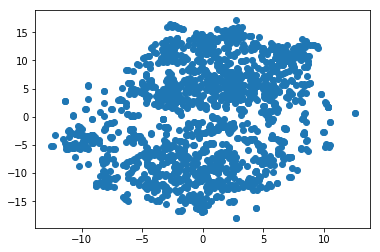

In [186]:
plt.scatter(*ttt.T)

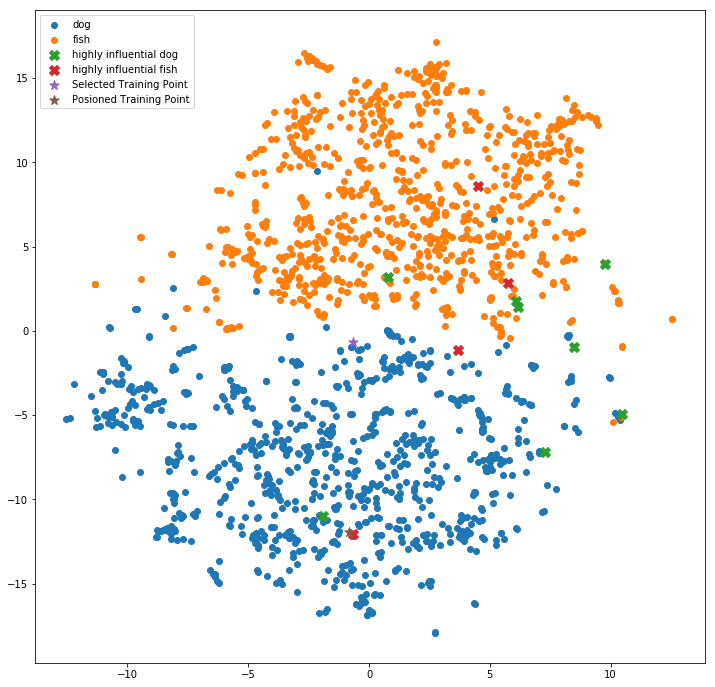

In [188]:
plt.figure(figsize=(12,12))
poisoned_incep = ttt[-1]
tsne_results = ttt[:1800]
labels = ["dog",  "fish", "highly influential dog", "highly influential fish"]

indices_dog = np.where(inception_X_train.labels == 0)
indices_fish = np.where(inception_X_train.labels == 1)
indices_all = [indices_dog, indices_fish]
normalized_pred_diff = pred_diff/np.linalg.norm(pred_diff)
indices_high = np.where(normalized_pred_diff > .1)

for class_label in range(num_classes):
    indices = indices_all[class_label]
    plt.scatter( tsne_results.T[0][indices], tsne_results.T[1][indices], label=labels[class_label]) 
for class_label in range(num_classes):
    indices = indices_all[class_label]
    high_ = np.where(np.in1d(indices_high, indices) == True)
    high = indices_high[0][high_]
    plt.scatter( tsne_results.T[0][high], tsne_results.T[1][high], label=labels[2 + class_label], marker='X', s=100)
plt.scatter( tsne_results.T[0][1141], tsne_results.T[0][1141], label="Selected Training Point", marker='*', s=100)
plt.scatter( poisoned_incep[[0]], poisoned_incep[[1]], label="Posioned Training Point", marker='*', s=100)
plt.legend()

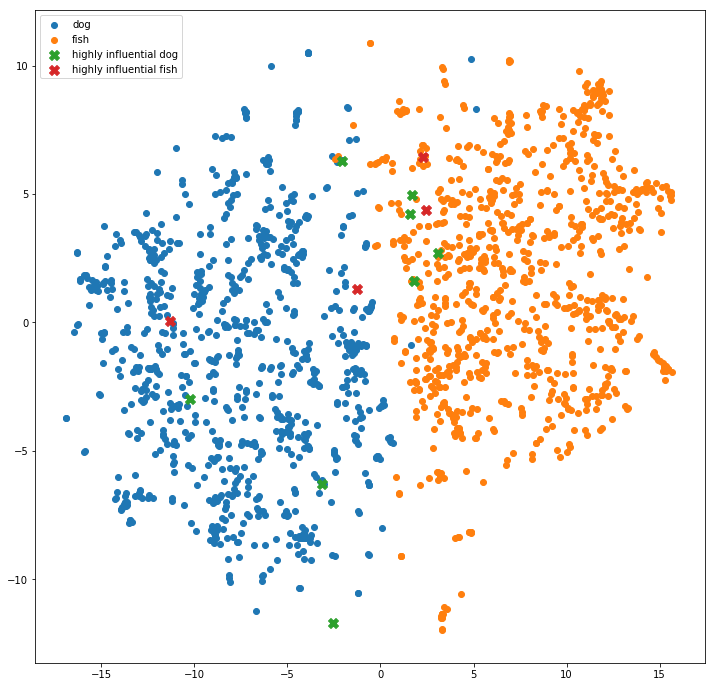

In [177]:
plt.figure(figsize=(12,12))

labels = ["dog",  "fish", "highly influential dog", "highly influential fish"]


indices_dog = np.where(inception_X_train.labels == 0)
indices_fish = np.where(inception_X_train.labels == 1)
indices_all = [indices_dog, indices_fish]
normalized_pred_diff = pred_diff/np.linalg.norm(pred_diff)
indices_high = np.where(normalized_pred_diff > .1)

for class_label in range(num_classes):
    indices = indices_all[class_label]
    plt.scatter( tsne_results.T[0][indices], tsne_results.T[1][indices], label=labels[class_label]) 
for class_label in range(num_classes):
    indices = indices_all[class_label]
    high_ = np.where(np.in1d(indices_high, indices) == True)
    high = indices_high[0][high_]
    plt.scatter( tsne_results.T[0][high], tsne_results.T[1][high], label=labels[2 + class_label], marker='X', s=100)
# plt.scatter( poisoned_incep[[0]], poisoned_incep[[1]], label="Posioned Training Point", marker='*', s=100)
plt.legend()

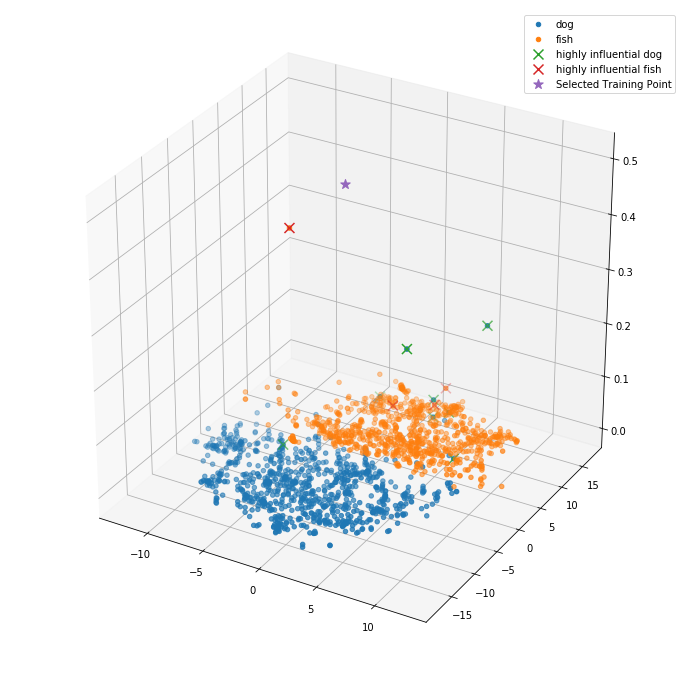

In [189]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

poisoned_incep = ttt[-1]
tsne_results = ttt[:1800]

indices_dog = np.where(inception_X_train.labels == 0)
indices_fish = np.where(inception_X_train.labels == 1)
indices_all = [indices_dog, indices_fish]
normalized_pred_diff = pred_diff/np.linalg.norm(pred_diff)
indices_high = np.where(normalized_pred_diff > .1)

# ax.plot_surface(tsne_results.T[0], tsne_results.T[1], pred_diff)

for class_label in range(num_classes):
    indices = indices_all[class_label]
    ax.scatter3D( tsne_results.T[0][indices], tsne_results.T[1][indices], normalized_pred_diff[indices], label=labels[class_label]) 
for class_label in range(num_classes):
    indices = indices_all[class_label]
    high_ = np.where(np.in1d(indices_high, indices) == True)
    high = indices_high[0][high_]
    ax.scatter3D( tsne_results.T[0][high], tsne_results.T[1][high], normalized_pred_diff[high], label=labels[2 + class_label], marker='x', s=100)
ax.scatter3D( tsne_results.T[0][1141], tsne_results.T[0][1141], normalized_pred_diff[1141], label="Selected Training Point", marker='*', s=100)
# ax.scatter3D( poisoned_incep[[0]], poisoned_incep[[1]], label="Posioned Training Point", marker='*', s=100)
plt.legend()


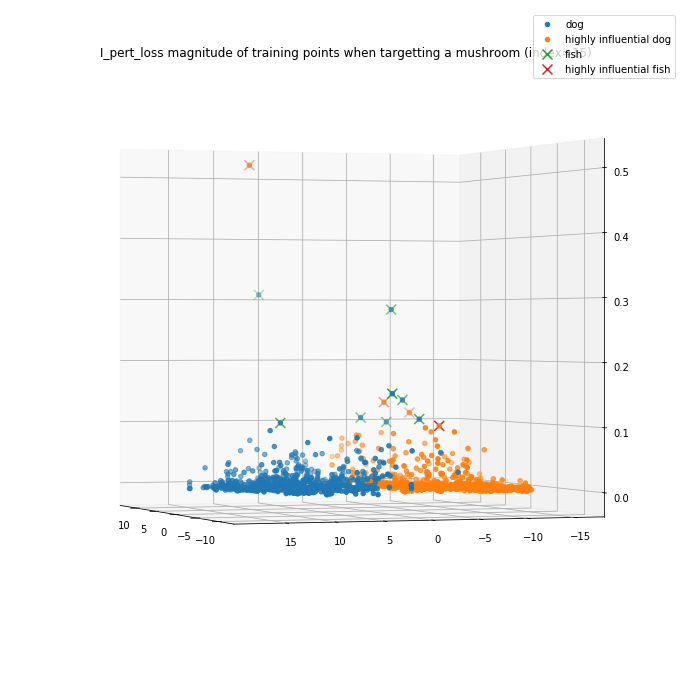

In [126]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(tsne_results.T[0], tsne_results.T[1], pred_diff)
plt.title("I_pert_loss magnitude of training points when targetting a mushroom (index={})".format(15))
normalized_pred_diff = pred_diff/np.linalg.norm(pred_diff)

labels = ["dog", "highly influential dog", "fish", "highly influential fish"]
indices_dog = np.where(inception_X_train.labels == 0)
indices_fish = np.where(inception_X_train.labels == 1)
indices_all = [indices_dog, indices_fish]
normalized_pred_diff = pred_diff/np.linalg.norm(pred_diff)
indices_high = np.where(normalized_pred_diff > .1)

ax.view_init(0, 160)
for class_label in range(num_classes):
    indices = indices_all[class_label]
    ax.scatter3D( tsne_results.T[0][indices], tsne_results.T[1][indices], normalized_pred_diff[indices], label=labels[class_label]) 
for class_label in range(num_classes):
    indices = indices_all[class_label]
    high_ = np.where(np.in1d(indices_high, indices) == True)
    high = indices_high[0][high_]
    ax.scatter3D( tsne_results.T[0][high], tsne_results.T[1][high], normalized_pred_diff[high], label=labels[2 + class_label], marker='x', s=100)
plt.legend()



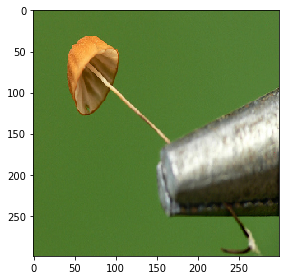

In [30]:
img = data_sets.train.x[706].reshape((img_side,img_side,num_channels)).copy()
render_img(img)

In [170]:
inception_X_train.x.shape
temp = np.vstack([inception_X_train.x, attack_success])

array([[0.38789767, 0.08201374, 0.32595792, ..., 0.17782016, 0.93120944,
        0.7886194 ]], dtype=float32)

In [153]:
attack_success
# invep = generate_inception_features(
#                 full_model, 
#                 np.array([attack_success]), 
#                 data_sets.train.labels[[1141]])
from keras import backend as K
feed_dict = {
            full_model.input_placeholder: attack_success,
            full_model.labels_placeholder: data_sets.train.labels[[1141]],            
            K.learning_phase(): 0
        }
full_model.sess.run(full_model.inception_features, feed_dict=feed_dict)

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("keras_learning_phase:0", dtype=bool) is not an element of this graph.

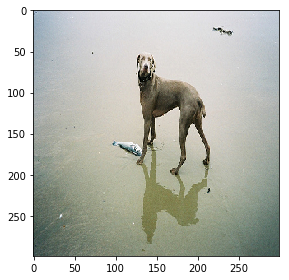

In [50]:
# render_img(attack_success)
img_attack = attack_success.reshape((img_side,img_side,num_channels))
render_img(img_attack)
print()

In [58]:
from keras.preprocessing import image

img2 = image.load_img("../../5classes/n01608432/n01608432_10016.JPEG")
img2.size

(500, 334)

In [56]:
img.size

(299, 299)

In [65]:
print(grad_influence_wrt_input_val_subset.shape)
pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
print(indices_to_poison)

(1500, 268203)
[ 698 1323  647  462  665  723  232  706  420 1143]


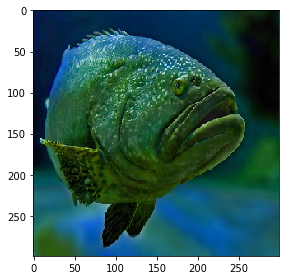

In [192]:
# for 15: 999,  172, 1302,  492, 1446,  164,  153, 1186,   47,  575
# 15, 6, 23
x = data_sets.train.x[1140]
# x = data_sets.train.x[1446]
# 999,  709, 1446
render_img(x.reshape((img_side,img_side,num_channels)))

In [194]:
data_sets.test.labels[179]

0.0

In [81]:
# all_indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
temp = np.array([1, 4, 3, 7, -2])
i1 = temp == 1
i2 = temp > 2
i = np.where(temp > 1)
i2 = np.where(temp == 4)

np.invert(np.in1d(i, i2))

array([False,  True,  True])

In [82]:
i

(array([1, 2, 3]),)

In [83]:
i2

(array([1]),)

In [30]:
dup = DataSet(np.copy(data_sets.test.x), np.copy(data_sets.test.labels))
dup.labels[2] = 5